In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import pickle

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
basedir = "G:\\My Drive\\Figures\\TwoTower\\SingleSession\\"

In [3]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [4]:
def PC_list_maker(mlist,firstSess = None):
    
    FR_dict = {}
    
    FR_dict[0],FR_dict[1]={},{}
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for i, (mouse,f_ind) in enumerate(zip(mlist,firstSess)): 

        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0]).tolist()):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
            VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
            trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)

            S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
            S_trial_mat[np.isnan(S_trial_mat)]=0
            
            
            
            S_morph_dict = u.trial_type_dict(S_trial_mat,trial_info['morphs'])
            
            S_mu,l = u.across_trial_avg(S_trial_mat,trial_info['morphs'])
            if i==0 and mat_ind==0:
                MU = S_mu
               
            else:
                MU = np.concatenate((MU,S_mu),axis=-1)
                
            
            pc_file = os.path.join(basedir,mouse,"%s_%s_%i" % (sess['Track'],sess['DateFolder'],sess['SessionNumber']),'pc_masks.pkl')
            try:
                with open(pc_file,'rb') as f:
                    masks = pickle.load(f)['masks']
            except:
                masks, FR, SI = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        VRDat['tstart']._values, VRDat['teleport']._values,
                        method='bootstrap',correct_only=False,speed=VRDat.speed._values,
                        win_trial_perm=True,morphlist=[0,1])
                with open(pc_file,'wb') as f:
                    pickle.dump({'masks':masks},f)
                
            fr_dict = pc.plot_placecells(S_morph_dict,masks,plot=False)
            
           
            for sort in [0,1]:
                for m in [0,.25,.5,.75,1.]:
                    if i==0 and mat_ind == 0:
                        
                        FR_dict[sort][m] = fr_dict[sort][m]
                    else:
                        FR_dict[sort][m]=np.concatenate((FR_dict[sort][m],fr_dict[sort][m]),axis=0)
    return FR_dict, MU
           
    

In [5]:
Rare_dict, Rare_mu = PC_list_maker(['4139265.5','4139265.4','4139265.3'])
Fam_dict, Fam_mu=PC_list_maker(['4222153.2','4222153.3','4222153.1','4222174.1'],firstSess=4)

session ind 5
num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0
session ind 6
num aberrant ttls 0.0
36018 (36018,) (36018, 21) 118606
frame diff 0
session ind 7
num aberrant ttls 0.0
40272 (40272,) (40272, 21) 133982
frame diff 0
session ind 8
num aberrant ttls 0.0
36659 (36659,) (36659, 21) 120387
frame diff 0
session ind 9
num aberrant ttls 0.0
36583 (36583,) (36583, 21) 124384
frame diff 0
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
frame diff 0
session ind 6
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
frame diff 0
session ind 7
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
frame diff 0
session ind 8
num aberrant ttls 0.0
31932 (31932,) (31932, 21) 105228
frame diff 0
session ind 9
num aberrant ttls 0.0
30493 (30493,) (30493, 21) 100982
frame diff 0
session ind 10
num aberrant ttls 0.0
32084 (32084,) (32084, 21) 105601
frame diff 0
session ind 5
num aberrant ttls 0.0
35085 (35085,) (35085, 21) 115307
frame diff 0
session ind 6
num aberrant ttls 0.0
33140 (33140,) (33140, 21) 109003
fram

In [6]:
def pop_PC_plot(FR_dict):
    f,ax = plt.subplots(2,5,figsize=[15,9])
    getSort = lambda fr : np.argsort(np.argmax(np.squeeze(fr),axis=1))
    sort0= getSort(FR_dict[0][0])
    sort1 = getSort(FR_dict[1][1])
    for i,sort in enumerate([sort0,sort1]):
        for j,m in enumerate([0,.25,.5,.75,1]):
            ax[i,j].imshow(FR_dict[i][m][sort,:],aspect='auto',cmap='pink',vmin=0.2,vmax=.9)
    return f,ax

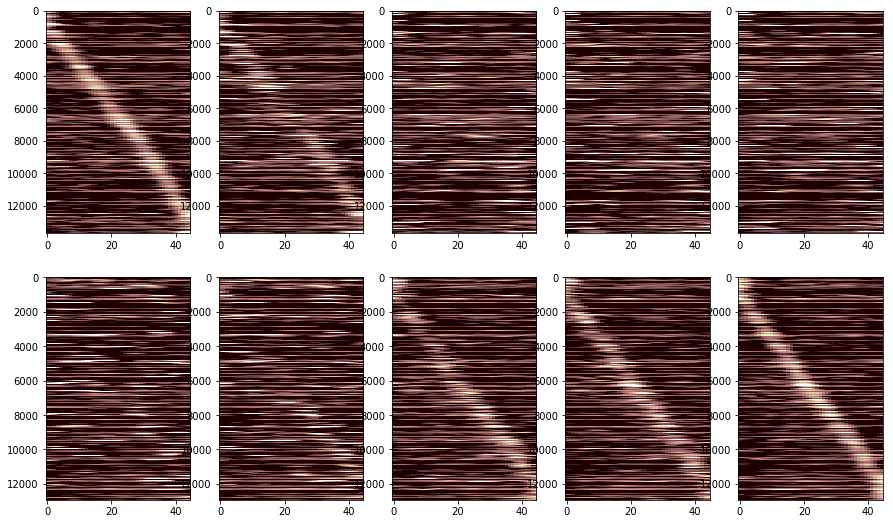

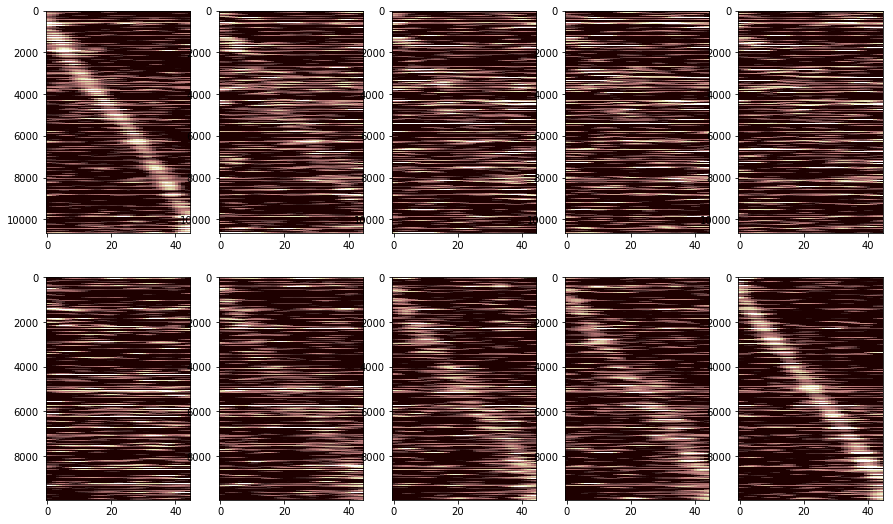

In [7]:
f_rare,ax_rare = pop_PC_plot(Rare_dict)

f_fam,ax_fam = pop_PC_plot(Fam_dict)

In [8]:
print(Rare_mu.shape)

(5, 45, 23408)


[[1.         0.69567094 0.46020296 0.43333244 0.44901639]
 [0.69567094 1.         0.53417402 0.50122359 0.51842448]
 [0.46020296 0.53417402 1.         0.73182331 0.75588662]
 [0.43333244 0.50122359 0.73182331 1.         0.78480401]
 [0.44901639 0.51842448 0.75588662 0.78480401 1.        ]]
[[1.         0.68731286 0.5938371  0.56556298 0.55663391]
 [0.68731286 1.         0.72878682 0.69962499 0.68731343]
 [0.5938371  0.72878682 1.         0.77611658 0.76715119]
 [0.56556298 0.69962499 0.77611658 1.         0.78407724]
 [0.55663391 0.68731343 0.76715119 0.78407724 1.        ]]


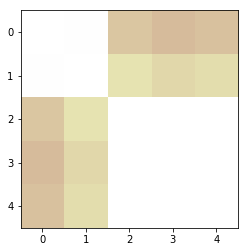

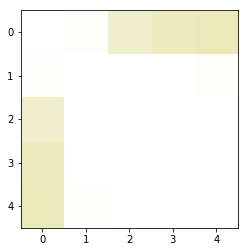

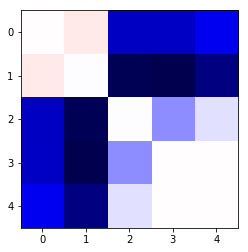

In [10]:

def mean_FR_corr(MU):
#     MU_z = sp.stats.zscore(MU,axis=-1)
#     mu_sim = np.matmul(np.transpose(MU_z,axes=[1,0,2]),np.transpose(MU_z,axes=[1,2,0])).mean(axis=0)/MU_z.shape[2]
#     print(mu_sim)
    MU_f = MU.reshape([MU.shape[0],-1])
    MU_f[np.isnan(MU_f)]=0
    MU_f /= np.linalg.norm(MU_f,2,axis=1)[:,np.newaxis]
    MU_f[np.isnan(MU_f)]=0
    mu_sim = np.matmul(MU_f,MU_f.T)
    print(mu_sim)
    f,ax = plt.subplots()
    ax.imshow(mu_sim,cmap='pink',vmin=.1,vmax=.7)
    return mu_sim

rare_mu_sim = mean_FR_corr(Rare_mu)
fam_mu_sim = mean_FR_corr(Fam_mu)

f,ax = plt.subplots()
ax.imshow(rare_mu_sim-fam_mu_sim,cmap='seismic',vmin=-.2,vmax=.2)

In [11]:
f_rare.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\AllPlaceCells_Rare.pdf",format='pdf')
f_fam.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\AllPlaceCells_Fam.pdf",format='pdf')

[[], []]
